In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

# Challenge 1 - clean the data

Import the data in ../data/economies_of_scale.csv into a pandas dataframe

In [14]:
#your code here

profit = pd.read_csv('economies_of_scale.csv')

In [15]:
profit.head()

,items_produced,total_profit
0,899,111K$
1,2051,5953K$
2,1613,822K$
3,1347,-1269K$
4,462,313K$


Notice the column *total_profit* is in text. You first need to clean this data to turn it back into numeric data. You can consider using the method *apply* or *replace* to do this

In [16]:
# clean the column total_profit to make it numeric

profit['total_profit'] = (
    profit['total_profit']
    .str.replace('$', '', regex=False)
    .str.replace('K', '', regex=False)
    .astype(float) * 1000
)

# Verificar el resultado
profit.head()

,items_produced,total_profit
0,899,111000.0
1,2051,5953000.0
2,1613,822000.0
3,1347,-1269000.0
4,462,313000.0


Now let's visualize how total profitability changes with number of machines sold

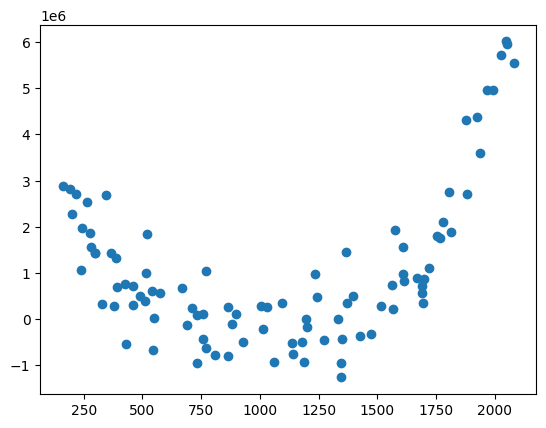

In [17]:
plt.scatter(profit['items_produced'], profit['total_profit'], label="Data")
plt.show()

This is an expected phenomenon called [*economies of scale*](https://en.wikipedia.org/wiki/Economies_of_scale): If you sell a very niche product (few sales) you can usuallyy charge a premium and have good profitability, since there will likely not be sufficient market for many competitors. As your product becomes more mainstream and more players enter the market, the supply pressures lower your profitability. Finally, once you break through to become a large player, as you expand your operations, your fixed costs become more and more diluted by the total number of items sold and your profitability increases again due to your lower operating costs.

In this exercise we are going to try to predict the profitability of the company based on the number of items sold.
Select your Features (X) and your Targets (y) and perform a test-train split.

In [18]:
from sklearn.model_selection import train_test_split

X = profit[['items_produced']]
y = profit['total_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Degree 1

Let's first approach this problem with a simple linear regression

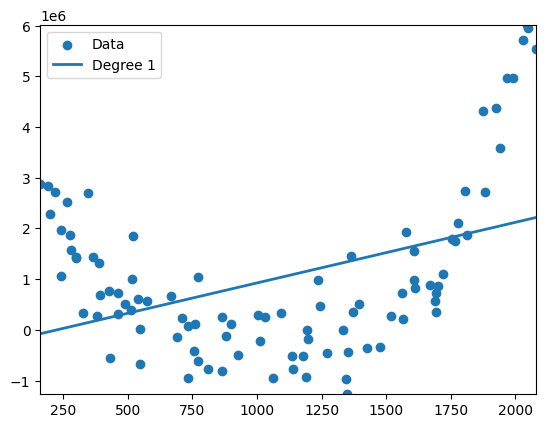

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_poly_train = scaler.fit_transform(X_train)
X_poly_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(X_plot))
plt.plot(X_plot, y_plot, label="Degree 1", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

We can easily see this is not a good model. It completely misses the niche side of the market and it does not approximate well  the profitability of the large players. This is a weak model with little generalization power.
This model exhibits *high bias*: the data DOES NOT fit well with the training data. It is however a nodel with *low variance*: the profit predicted  swings in expected ways with the sold units.
This is typical in cases of *Underfitting*.

# Degree 2

We are going to introdduce a common regression technique called *polynomial regression*. When you have a single feature $X$ and you apply a linear regression you are finding the optimal coefficientf for the formula

$$ y = \beta_0 + \beta_1 X $$

We are going to create new features by considering powers of the base feature $X$, so a *quadratic* regression would produce the optimal coefficients for the formula

$$y = \beta_0 + \beta_1 X + \beta_2 X^2$$

and a *cubic* regression would produce the optimal coefficients for the formula

$$y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3$$

and so on.

This way, with a single feature *X* you can produce multiple features $X^2$, $X^3$, etc to apply a higher dimensional Linear Regression. We create these extra features $X^2$, $X^3$ using a sklearn preprocessing tool called *PolynomialFeatures*

In [20]:
#polynomial features of degree 1 gives us a constant term plus the linear term
from sklearn.preprocessing import PolynomialFeatures

X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=1)
poly_features.fit_transform(X_example)

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 5.]])

In [21]:
#polynomial features of degree 2 gives us a constant term plus the linear term, plus a quadratic term
X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=2)
poly_features.fit_transform(X_example)

array([[ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  5., 25.]])

In [22]:
#polynomial features of degree 2 gives us a constant term plus the linear term, plus a cubic term
X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=3)
poly_features.fit_transform(X_example)

array([[  1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.],
       [  1.,   3.,   9.,  27.],
       [  1.,   5.,  25., 125.]])

And so on. So, if we want to use a quadratic approximation to this problem we run the following code

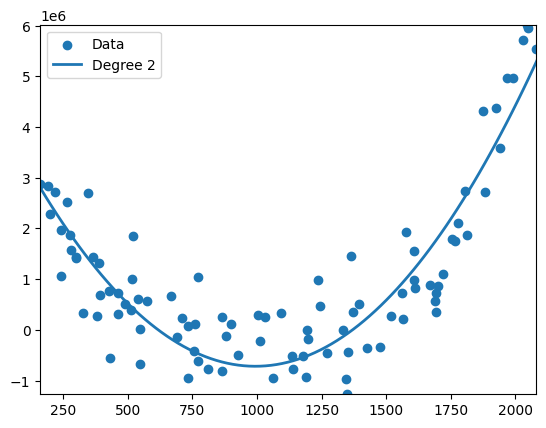

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=2)  # here is where the 2 comes in
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 2", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

You can see the fit obviously looks much better just by visual inspection. Let's keep it going...

# Challenge 2 -Degree 4

Replicate the exercise above but now for degree 4. Is the fit improving?

In [25]:
X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=4)
poly_features.fit_transform(X_example)

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   5.,  25., 125., 625.]])

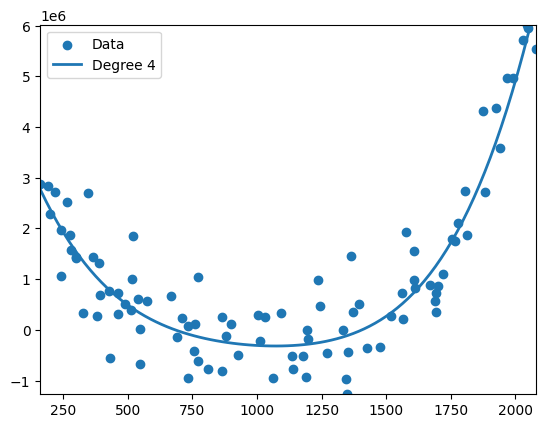

In [26]:
#necesito hacer el mismo grafico que arriba pero con el grado 4
scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=4)
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 4", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()


It seems like we keep increasing the fit. The model has more variance, but it also loses more bias in a way that seems like a good tradeoff!

# Challenge 3 -High degrees

so... should we keep this going forever?
Replicate the exercise above but now for degrees 12, 16, 20.... Is the fit improving? Why?

(Bonus question for you to consider: why am I only asking for even degrees?)

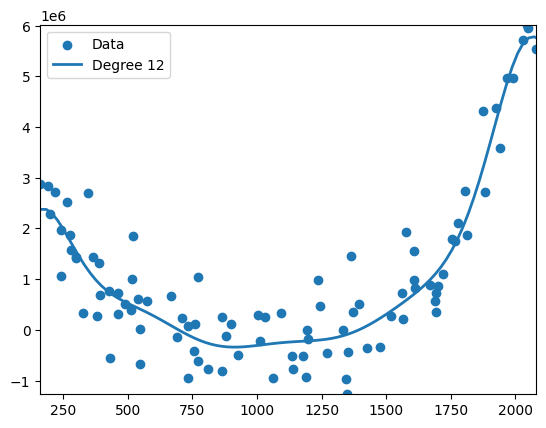

In [27]:
scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=12)
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 12", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

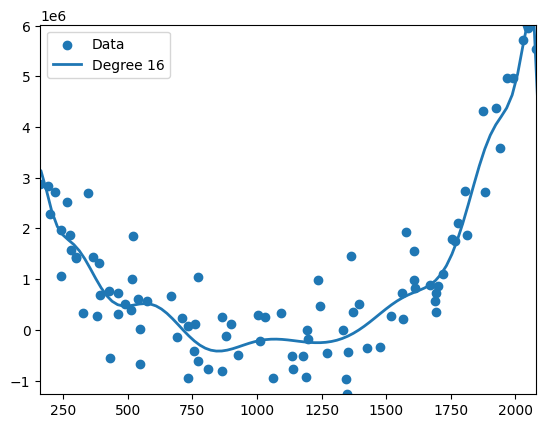

In [28]:
scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=16)
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 16", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

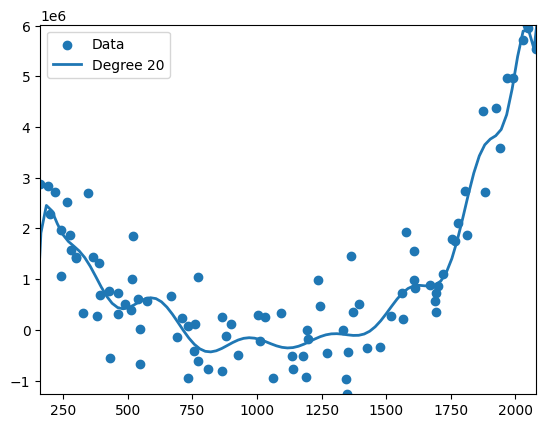

In [29]:
scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=20)
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 20", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

It looks like the more powerufl models are starting to behave in erratic ways, trying to fit too closely to the training data.
They are getting *lower bias*: the data DOES fit better with the training data...
... but the cost of that is *higher variance*: the models becomes swingy and it seems that it's not reflecting real patterns in the data.

# Challenge 4 -Visualizing errors

Let's see what happens to the errors.
Run the code above in a loop and collect the *train_error* and *test_error* for each degree. Then plot them all.

In [30]:
degrees = [1, 2, 4, 12, 16, 20]
train_errors = []
test_errors = []

for degree in degrees:
  poly_features = PolynomialFeatures(degree=degree)
  X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
  X_poly_test = scaler.transform(poly_features.transform(X_test))
  model = LinearRegression()
  model.fit(X_poly_train, y_train)
  y_train_pred = model.predict(X_poly_train)
  y_test_pred = model.predict(X_poly_test)
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error
  train_errors.append(train_error)
  test_errors.append(test_error)




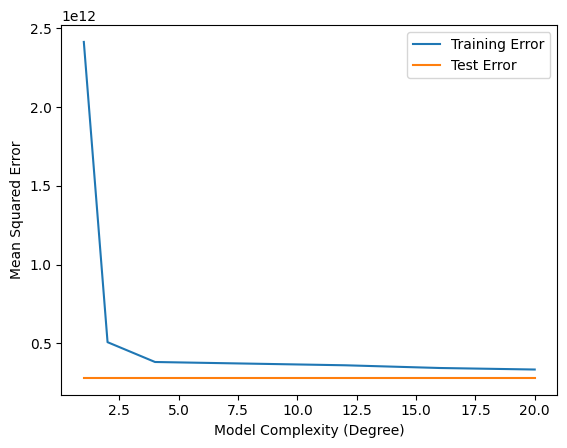

In [31]:
plt.plot(degrees, train_errors, label="Training Error")
plt.plot(degrees, test_errors, label="Test Error")
plt.xlabel("Model Complexity (Degree)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

You see that the training error keeps going down. That is expected: higher order models are more powerful but they start having enough power to fit the noise in the training data. Because of this you see the testing error going up at some point: your model believes natural variation in the training data is part of the fundamental mechanist you are trying to learn and will not be able to generalize. It becomes *overfit*.

# Optional Challenge - Regularization

Regularization is a way of controlling overfitting by imposing a price on the variance of the model.
Re-run the high dimentionality *degree 20* case above but run a Lasso regression rather than a LinearRegression, with a significant penalty for runaway coefficients.

Hint: where you have
`model = LinearRegression()`
use instead
`model = Lasso(alpha=100)`

In [ ]:
from sklearn.linear_model import Lasso

#your code here

And now redo the test_error vs train_error plotting above, but using a Lasso regession rather than a linear regression.

What happens to the bias-variance tradeoff in this case?

In [ ]:
degrees = [1, 2, 4, 12, 16, 20]
train_errors = []
test_errors = []

for degree in degrees:
    #your code here

plt.plot(degrees, train_errors, label="Training Error")
plt.plot(degrees, test_errors, label="Test Error")
plt.xlabel("Model Complexity (Degree)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()